# Урок 8. Снижение размерности данных 

1. Можно ли отобрать наиболее значимые признаки с помощью PCA?
2. (\*) Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции [numpy.linalg.svd()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)
3. (\*) Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

Реализация PCA из методички.

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [3]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по признаку
means = X_.mean(axis=0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for j in range(cols):
    for i in range(rows):
        X_[i, j] /= std[j]

In [4]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

Собственные значения в порядке убывания:
437.7746724797991
137.1045707202105
22.0135313356972
3.1072254642928656


Оценим долю дисперсии, которая описывается найденными компонентами.

In [5]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описвыаемая каждой из компонент 
[72.9624454132999, 22.850761786701764, 3.6689218892828688, 0.517870910715478]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Таким образом, первая главная компонента описывает почти 73% информации, а первые две в сумме - 95.8%. В то же время последняя компонента описывает всего 0.5% и может быть отброжена без страха значительных потерь в качестве нашего анализа. Мы отбросим последние две компоненты, оставив первые две.

In [6]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [7]:
# Сформируем новую матрицу "объекты-признаки"
Z = X_.dot(W)
Z.shape

(150, 2)

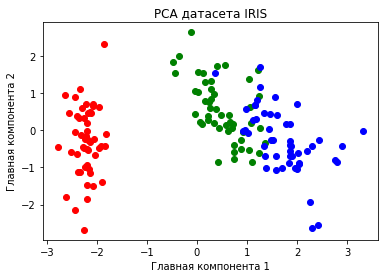

In [8]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

Таким образом, мы перешли от четырехмерного пространства признаков к двумерному и при этом классы остались разделимы в пространстве, то есть классификация возможна.

### Задание 2

Напишем реализацию метода главных компонент с помощью сингулярного разложения.
$$X=UDV^{T}$$

In [9]:
def pca_svd(X, k):
    U, D, V = np.linalg.svd(X)
    #новая матрица признаков из k компонент
    Z = X @ V.T[:, :k]
    return Z, V.T[:, :k] 

In [10]:
Z_svd, W_svd = pca_svd(X_, 2)
print(f'Матрица весов PCA:\n', W)
print(f'Матрица весов PCA_SVD:\n', W_svd)

Матрица весов PCA:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]
Матрица весов PCA_SVD:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


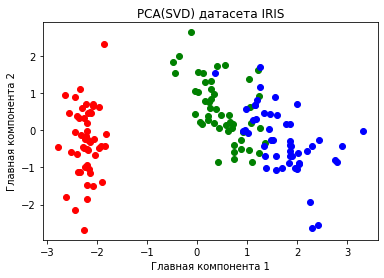

In [11]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z_svd[y==i, 0], Z_svd[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA(SVD) датасета IRIS')
plt.show()

### Задание 3
Обучим случайный лес (наша реализация) на датасете IRIS до применения PCA и после него. Сравним качество классификации по отложенной выборке.

In [12]:
from models import *

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)
forest = random_forest(X_train, y_train, 5)
y_pred = tree_vote(forest, X_test)
accuracy_metric(y_test, y_pred)

100.0

In [16]:
Z_svd, _ = pca_svd(X_, 2)
X_train, X_test, y_train, y_test = train_test_split(Z_svd, y, test_size=0.3, random_state=42)
forest_ = random_forest(X_train, y_train, 5)
y_pred = tree_vote(forest_, X_test)
accuracy_metric(y_test, y_pred)

95.55555555555556

Точность алгоритма после PCA несколько снизилась.